# Correlations

**Goal:** Test if the correlations of modelling multiple variables are helping or not!

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import json

import matplotlib.pyplot as plt
from matplotlib import gridspec
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  


from sklearn.preprocessing import StandardScaler
from scipy.stats import binned_statistic_2d, chisquare
from scipy.stats import norm 

import os
os.sys.path.append('../code')
from plotting import SR_x, SR_y1, SR_y2
from eventDisplays import rainbow_text

import torch
from torch import nn
from torch.distributions import Normal, Categorical,OneHotCategorical

from mdn import MixtureDensityNetwork
from densityEstimate import *
from densityPlots import *

%load_ext autoreload
%autoreload 2

Running w/ conda env: don't import root packages.


**Step 1: Test that my correlation plotting code is working**

In [172]:
d = data()

# Add the 2b and deta_hh cuts
mh1_mask = (d.df.m_h1 > 126-45) & (d.df.m_h1 < 126+45)
mh2_mask = (d.df.m_h2 > 116-45) & (d.df.m_h2 < 116+45)
mask = mh1_mask & mh2_mask 

mask = mask & (d.df.abs_deta_hh < 1.5) & (d.df.ntag==2)


cols = ['log_m_hh_cor2','absCosThetaStar']
d.mlPrepare(mask,cols)

../data/data_16_PFlow-MAY2019-5jets/df_f_0.22_NNT_HCs.h5


In [3]:
subDir = f'{d.subDir}_2b_detaCut'
lr, decay, L, hid_dim = 1e-3, 1e-6, 5, 64
rnvp = RealNVP(subDir, lr, decay, cols, 0, L, hid_dim,load_model=True)


# Ok - I kind of also wanted to try loading in the R-NVP 
# rnvp.modelDir = f'models/rnvp_{L}layer_H_{H}_lr_{lr}_decay_{decay}/'
# for epoch in np.arange(0,1001,100):
#     rnvp.model.load_state_dict(torch.load(rnvp.modelDir+f'model_epoch{epoch}.pt'))

#     print(epoch,rnvp.loss(d.X_tr,d.Y_tr).item(),rnvp.loss(d.X_SR,d.Y_SR).item())

lr = 0.001, weight decay = 1e-06, iter = 0, cols = ['log_m_hh_cor2', 'absCosThetaStar']
Setting up a R-NVP model with 5 layers, hidden_dim=64
tensor([0., 1.])


In [4]:
print(rnvp.loss(d.X_tr,d.Y_tr).item(),rnvp.loss(d.X_SR,d.Y_SR).item())

2.7027697563171387 2.8350696563720703


In [5]:
rnvp.modelDir

'models/data_16_PFlow-MAY2019-5jets_2b_detaCut//rnvp_log_m_hh_cor2_absCosThetaStar_5_layers_H_64_lr_0.001_1e-06_iter0/'

In [6]:
rnvp.model.training

False

In [7]:
rp = RealNVP_Plots(rnvp, save=False)

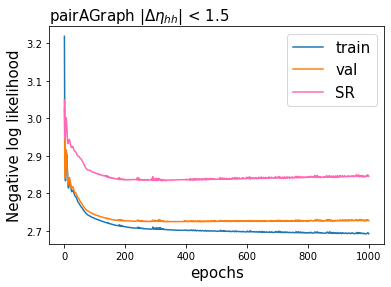

In [8]:
filename = f'{rnvp.modelDir}/loss_acc.json'
with open(filename, 'r') as varfile:
    metrics = json.load(varfile)
    
trainingMetric(metrics,title='pairAGraph $|\Delta \eta_{hh}|$ < 1.5')

Compare the training curve to the model w/o the $|\Delta \eta_{hh}| < 1.5$ cut.

To calculat the loss on the model trained w/o the $\Delta \eta_{hh}$ cut, need the scalar used.

In [9]:
cols

['log_m_hh_cor2', 'absCosThetaStar']

In [10]:
d2 = data()
m2 = mh1_mask & mh2_mask  & (d.df.ntag==2)

d2.mlPrepare(m2,cols)

../data/data_16_PFlow-MAY2019-5jets/df_f_0.22_NNT_HCs.h5


In [11]:
d.scalar.mean_

array([122.81768801, 105.99800636,   5.06425657,   0.3936192 ])

In [12]:
d2.scalar.mean_

array([127.25687556, 109.03041751,   5.30521872,   0.64250089])

In [13]:
X_SR2 = (d.df.loc[mask,['m_h1','m_h2']].values - d2.scalar.mean_[:2]) / d2.scalar.scale_[:2]
Y_SR2 = (d.df.loc[mask,cols].values - d2.scalar.mean_[2:]) /  d2.scalar.scale_[2:]

X_SR2 = torch.tensor(X_SR2).float()
Y_SR2 = torch.tensor(Y_SR2).float()

lr = 0.001, weight decay = 1e-06, iter = 0, cols = ['log_m_hh_cor2', 'absCosThetaStar']
Setting up a R-NVP model with 5 layers, hidden_dim=64
tensor([0., 1.])


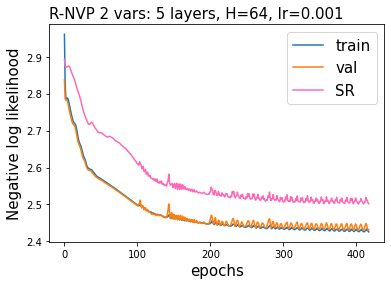

In [14]:
subDir2 = f'{d.subDir}_2b'
rnvp2 = RealNVP(subDir2, lr, decay, cols, 0, L, hid_dim,load_model=True)

filename = f'{rnvp2.modelDir}/loss_acc.json'
with open(filename, 'r') as varfile:
    metrics = json.load(varfile)
        
trainingMetric(metrics,title=f'R-NVP 2 vars: {L} layers, H={H}, lr={lr}',
               figName=f'figures/{rnvp2.modelDir[7:]}/loss.pdf')

In [15]:
rnvp2.loss(d2.X_SR,d2.Y_SR)

tensor(2.5017, grad_fn=<NegBackward>)

In [16]:
#rnvp2.loss(d.X_SR,d.Y_SR)

In [17]:
rnvp2.loss(X_SR2,Y_SR2)

tensor(2.9662, grad_fn=<NegBackward>)

**Conclusion:** Training before $|\Delta \eta_{hh}| < 1.5$ and eval *after* doesn't work for only training with 2 variables.

(Makes sense, b/c w/ only 2 variables, it doesn't have the necessary information to do this.)

In [18]:
rp2 = RealNVP_Plots(rnvp2, save=True)

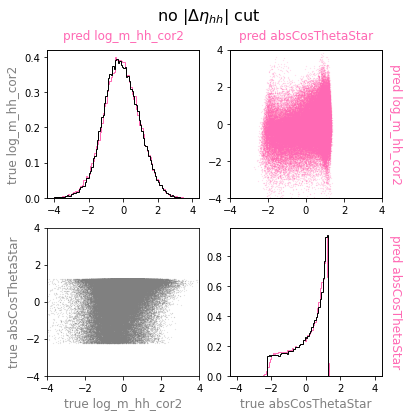

In [19]:
rp2.plot_correlations(d2.X_SR, d2.Y_SR, 'hotpink', mvars=cols, tag='_SR',
                      title='no $|\Delta \eta_{hh}|$ cut')

**Note to self:** This model performed *a lot* worse when I was loading it in the training mode, so this BatchNorm layer is making a *big* difference between the training and testing phases.

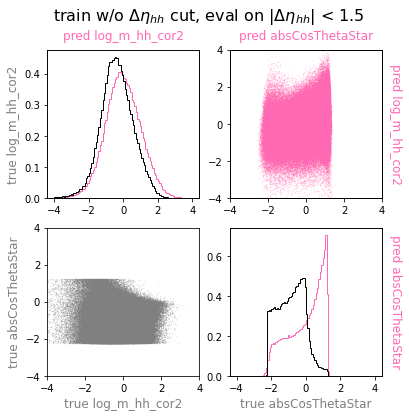

In [20]:
rp2.plot_correlations(X_SR2, Y_SR2, 'hotpink', mvars=cols, tag='_SR_evalDetaCut',
                      title='train w/o $\Delta \eta_{hh}$ cut, eval on $|\Delta \eta_{hh}|$ < 1.5')

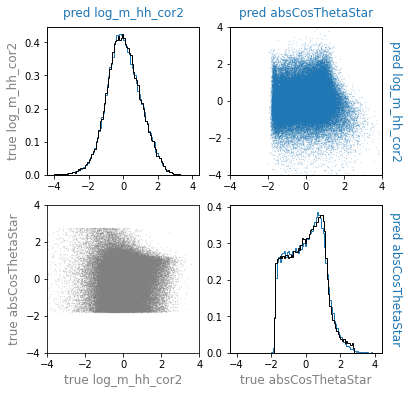

In [21]:
rp.plot_correlations(d.X_tr, d.Y_tr, 'C0', cols)

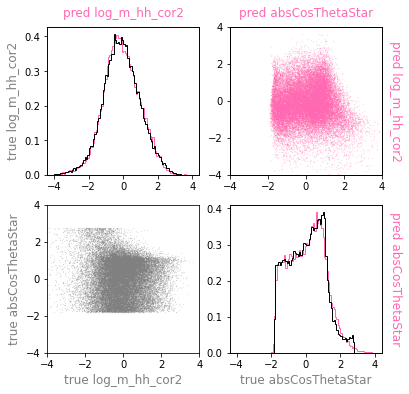

In [22]:
rp.plot_correlations(d.X_SR, d.Y_SR, 'hotpink', cols)

So I think the plot is correctly labelled (now), but it's not simply a reflection.

/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/Flow-Models/densityPlots.py:369: RuntimeWarning: divide by zero encountered in true_divide
  axb.errorbar(xx, n0 / n1, err/n1, fmt='.', color=color,
/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/Flow-Models/densityPlots.py:369: RuntimeWarning: invalid value encountered in true_divide
  axb.errorbar(xx, n0 / n1, err/n1, fmt='.', color=color,
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:3322: RuntimeWarning: invalid value encountered in double_scalars
  low = [v - e for v, e in zip(data, a)]


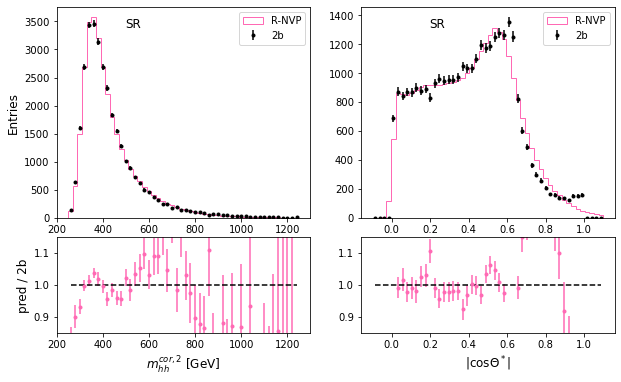

In [23]:
rp.medianMarginals(d.X_SR,d.Y_SR,d,nb=50,rs=[(250,1250),(-0.1,1.1)])

In [24]:
rnvp.loss(d.X_SR,d.Y_SR)

tensor(2.8351, grad_fn=<NegBackward>)

But... *awesome* this is exactly the plot that I want to be looking at!!

**To do:** Overlay with the MDN prediction!

In [25]:
nb = 50
r = [250,1250]

lr = 0.005, weight decay = 0, iter = 0, cols = ['log_mhh_cor2']


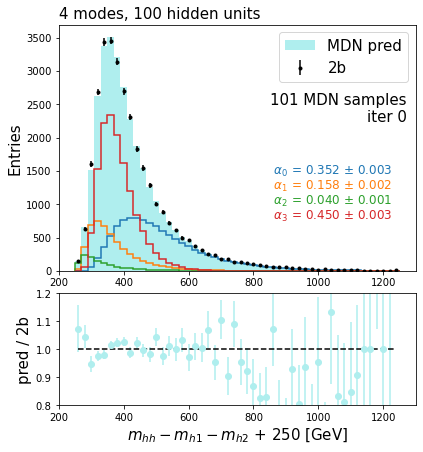

In [246]:
K, H = 4, 100

subDir = f'{(d.subDir)}_2b_detaCut'

mdn = MDN(subDir,5e-3,0,['log_mhh_cor2'],0,K,H,load_model=True)
mp = MDN_Plots(mdn,save=True)     

X_SR, Y_SR = d.X_SR, d.Y_SR[:,0]
title = f'{K} modes, {H} hidden units'
mp.samplePrediction(X_SR,Y_SR,nPreds=101,d=d,title=title,col='m_hh_cor2',
                    nb=50,r=(250,1250),loc=(850,1500)) 

Oooh - cool!!

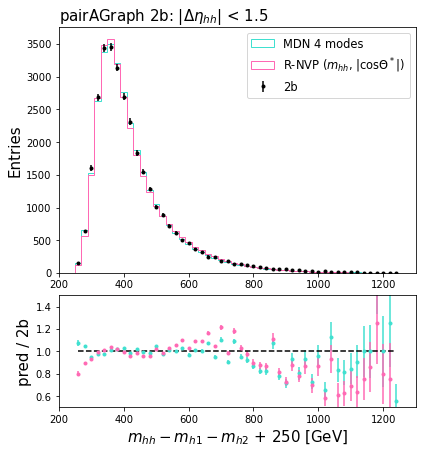

In [247]:
fig = plt.figure(figsize=(6.4, 7))
gs = gridspec.GridSpec(3,1)
ax1 = fig.add_subplot(gs[:2,0])
ax2 = fig.add_subplot(gs[2:,0],sharex=ax1)

# Overlay the predictions
n0,_,_ = ax1.hist(mp.xx,nb,r,color='turquoise',label='MDN 4 modes',
                  histtype='step', weights=mp.n_pred)

ni = np.median(np.sum(rp.hist3d,axis=-1),axis=0)
n1,_,_ = ax1.hist(mp.xx,nb,r,color='hotpink',label='R-NVP ($m_{hh}$, $|\cos \Theta^*|$)',
                  histtype='step', weights=ni)

ax1.errorbar(mp.xx, mp.n_2b, np.sqrt(mp.n_2b), color='k',label='2b',fmt='.')

# Ratios
ax2.errorbar(mp.xx, n0/mp.n_2b, np.sqrt(mp.err)/mp.n_2b, color='turquoise',fmt='.')

err = np.std(np.sum(rp.hist3d,axis=-1),axis=0)
ax2.errorbar(mp.xx, n1/mp.n_2b, np.sqrt(err)/mp.n_2b, color='hotpink',fmt='.')

# Make the plot pretty!
ax1.set_ylabel('Entries',fontsize=15)
ax1.legend(fontsize=11.5)
ax1.set_title('pairAGraph 2b: $|\Delta \eta_{hh}|$ < 1.5',fontsize=15,loc='left')
#ax1.text(.025,.96,f'{mp.nPreds} samples\nper training',ha='left',va='top',fontsize=15,transform=ax1.transAxes)

ax2.plot(mp.xx,np.ones_like(mp.xx),'k--')
ax2.set_xlabel('$m_{hh} - m_{h1} - m_{h2}$ + 250 [GeV]',fontsize=15)
ax2.set_ylabel('pred / 2b',fontsize=15)
ax2.set_ylim(.5,1.5)

#plt.savefig(f'figures/{subDir}/mdn_5_H_100_lr_0.005_11splits/log_m_hh_cor2_med_SR.pdf',bbox_inches='tight')
plt.show()

Ok, at this stage, I would say the two models are *comparable*.

**Remake plot with *optimized* R-NVP**



In [282]:
lr, decay, L, hid_dim = 1e-3, 1e-3, 5, 16
rnvp3 = RealNVP(subDir, lr, decay, cols, 0, L, hid_dim,load_model=True)

lr = 0.001, weight decay = 0.001, iter = 0, cols = ['log_m_hh_cor2', 'absCosThetaStar']
Setting up a R-NVP model with 5 layers, hidden_dim=16
tensor([0., 1.])


In [283]:
rp3 = RealNVP_Plots(rnvp3, save=True)

In [284]:
rnvp3.loss(d.X_SR,d.Y_SR)

tensor(2.8221, grad_fn=<NegBackward>)

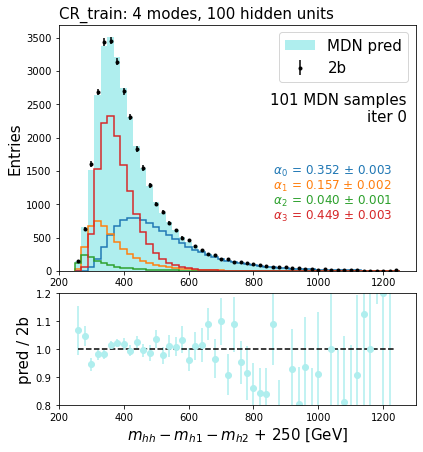

In [285]:
mp.samplePrediction(X_SR,Y_SR,nPreds=101,d=d,title=title,col='m_hh_cor2',
                    nb=50,r=(250,1250),loc=(850,1500)) 

/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/Flow-Models/densityPlots.py:368: RuntimeWarning: divide by zero encountered in true_divide
  err = np.std(ni,axis=0)
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:3322: RuntimeWarning: invalid value encountered in double_scalars
  low = [v - e for v, e in zip(data, a)]


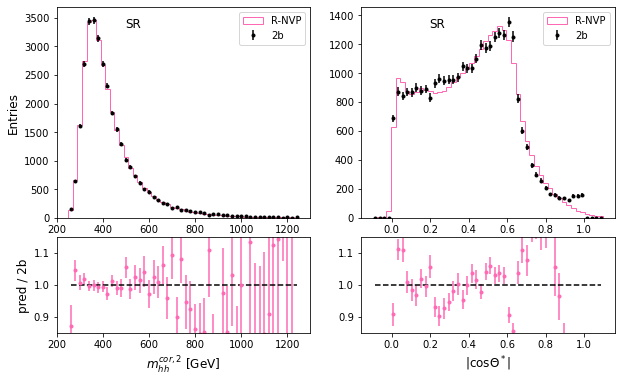

In [286]:
rp3.medianMarginals(d.X_SR, d.Y_SR, d, nb=50, rs=[(250,1250),(-0.1,1.1)])

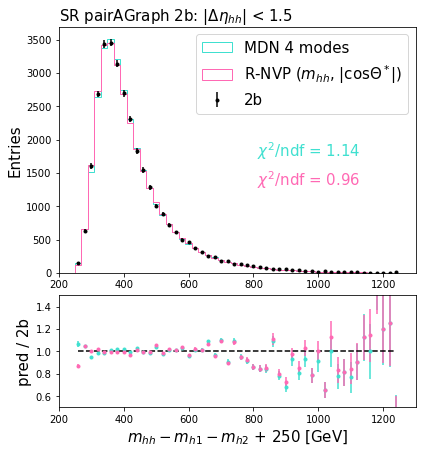

In [287]:
fig = plt.figure(figsize=(6.4, 7))
gs = gridspec.GridSpec(3,1)
ax1 = fig.add_subplot(gs[:2,0])
ax2 = fig.add_subplot(gs[2:,0],sharex=ax1)

# Overlay the predictions
n0,_,_ = ax1.hist(mp.xx,nb,r,color='turquoise',label='MDN 4 modes',
                  histtype='step', weights=mp.n_pred)

ni = np.median(np.sum(rp3.hist3d,axis=-1),axis=0)
n1,_,_ = ax1.hist(mp.xx,nb,r,color='hotpink',label='R-NVP ($m_{hh}$, $|\cos \Theta^*|$)',
                  histtype='step', weights=ni)

ax1.errorbar(mp.xx, mp.n_2b, np.sqrt(mp.n_2b), color='k',label='2b',fmt='.')

# Ratios
ax2.errorbar(mp.xx, n0/mp.n_2b, np.sqrt(mp.err)/mp.n_2b, color='turquoise',fmt='.')

err = np.std(np.sum(rp3.hist3d,axis=-1),axis=0)
ax2.errorbar(mp.xx, n1/mp.n_2b, np.sqrt(err)/mp.n_2b, color='hotpink',fmt='.')

# Make the plot pretty!
ax1.set_ylabel('Entries',fontsize=15)
ax1.legend(fontsize=15)
ax1.set_title('SR pairAGraph 2b: $|\Delta \eta_{hh}|$ < 1.5',fontsize=15,loc='left')
#ax1.text(.025,.96,f'{mp.nPreds} samples\nper training',ha='left',va='top',fontsize=15,transform=ax1.transAxes)

ax2.plot(mp.xx,np.ones_like(mp.xx),'k--')
ax2.set_xlabel('$m_{hh} - m_{h1} - m_{h2}$ + 250 [GeV]',fontsize=15)
ax2.set_ylabel('pred / 2b',fontsize=15)
ax2.set_ylim(.5,1.5)

# Add chi2 metric for comparison
ls = []
for f_obs in [n0,ni]:
    chi2ndf = chisquare(f_obs,mp.n_2b,nb-1)[0]/(nb-1)
    ls.append(f"$\chi^2$/ndf = {chi2ndf:.2f}\n")
lc = ['turquoise','hotpink']
rainbow_text(800,2000,ls,lc,ax=ax1,ha='left',va='top',yoffset=.75,fontsize=15)

plt.savefig(f'{rp3.figDir}/m_hh_cor2_SR_cf_mdn_4modes.pdf',bbox_inches='tight')
plt.show()


**Message:** They're actually pretty comparable!!

**Question:** When the models fluctuate in the same way, is this due to a fluctuation in the 2b SR?

**Plan:** Split the SR dataset in half, and separately compare the predictions

**Next:** I think it's important to *compare* the fits in the CR and VR b/c this will help give me a handle on if it's the *interpolation* that's limiting the models.

In [288]:
allCols = ['m_h1','m_h2'] + cols

In [289]:
H

100

/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/Flow-Models/densityPlots.py:368: RuntimeWarning: divide by zero encountered in true_divide
  err = np.std(ni,axis=0)
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:3322: RuntimeWarning: invalid value encountered in double_scalars
  low = [v - e for v, e in zip(data, a)]


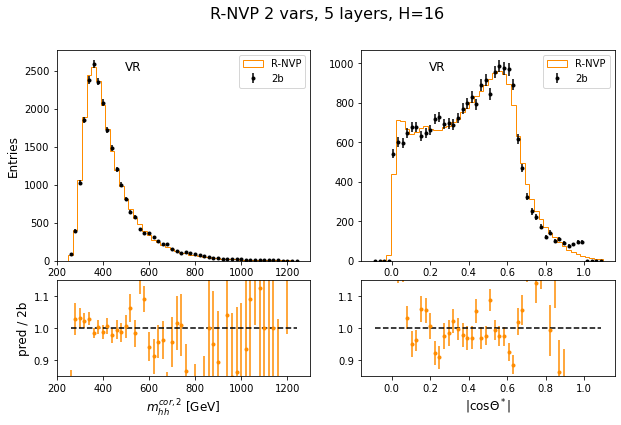

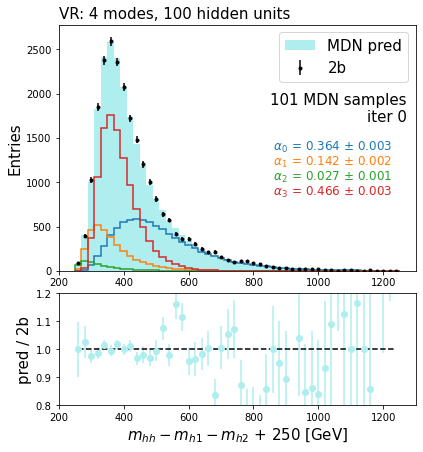

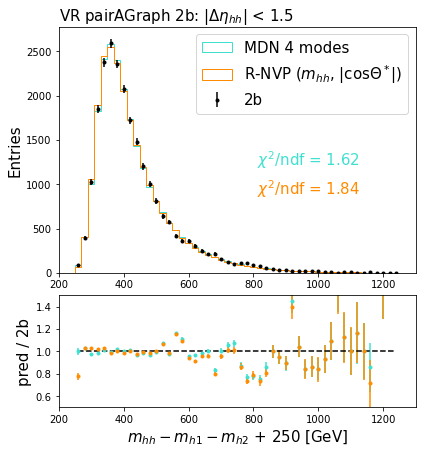

/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/Flow-Models/densityPlots.py:368: RuntimeWarning: divide by zero encountered in true_divide
  err = np.std(ni,axis=0)
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:3322: RuntimeWarning: invalid value encountered in double_scalars
  low = [v - e for v, e in zip(data, a)]


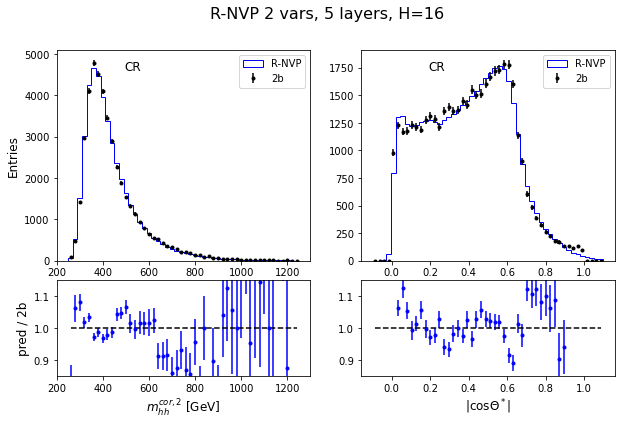

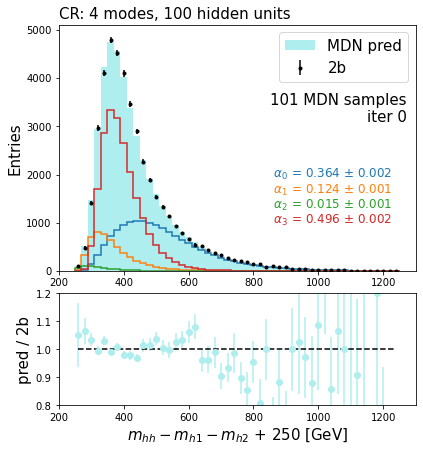

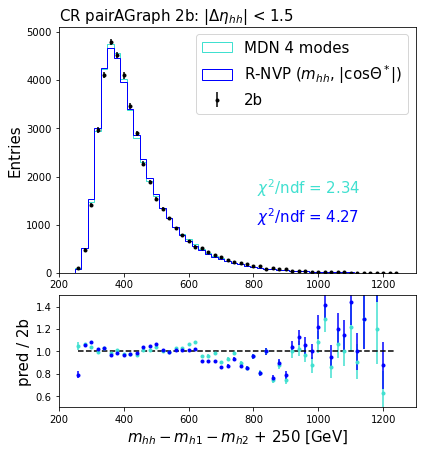

/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/Flow-Models/densityPlots.py:368: RuntimeWarning: divide by zero encountered in true_divide
  err = np.std(ni,axis=0)
/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/Flow-Models/densityPlots.py:368: RuntimeWarning: invalid value encountered in true_divide
  err = np.std(ni,axis=0)
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:3322: RuntimeWarning: invalid value encountered in double_scalars
  low = [v - e for v, e in zip(data, a)]


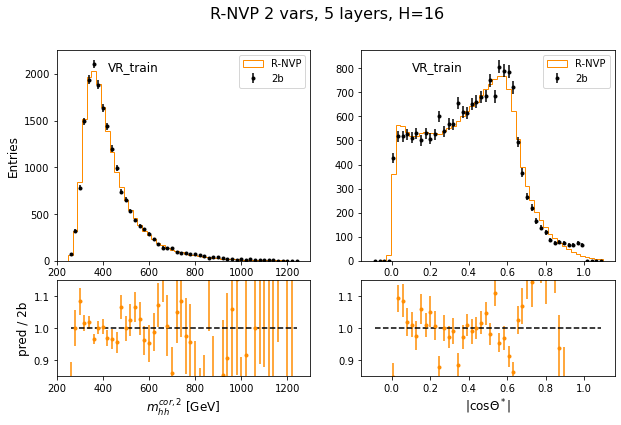

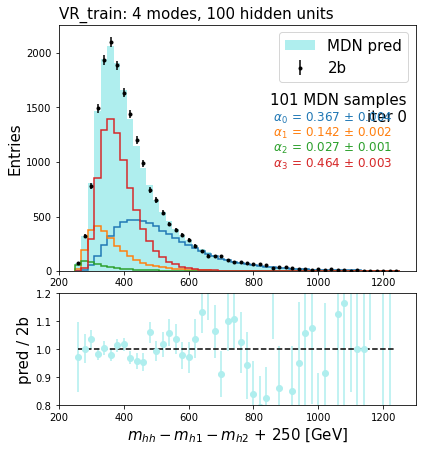

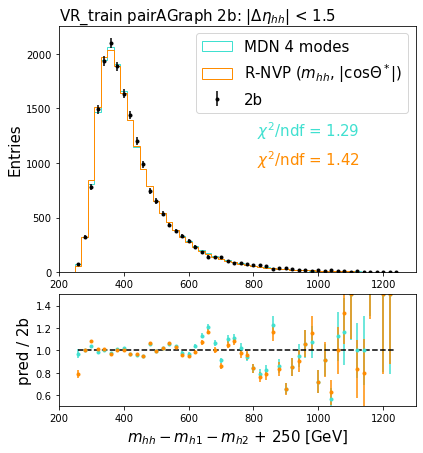

/gpfs/slac/atlas/fs1/d/nhartman/diHiggs4b/Flow-Models/densityPlots.py:368: RuntimeWarning: divide by zero encountered in true_divide
  err = np.std(ni,axis=0)
/gpfs/slac/atlas/fs1/d/rafaeltl/public/conda/miniconda3/envs/py3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:3322: RuntimeWarning: invalid value encountered in double_scalars
  low = [v - e for v, e in zip(data, a)]


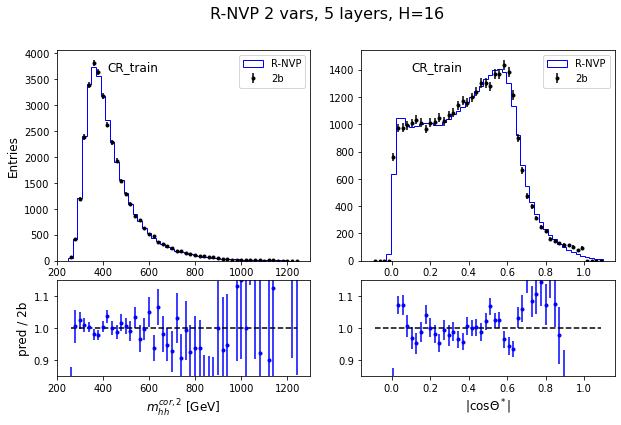

In [ ]:
for split,splitTag in zip(['test','train'],['','_train']):

    for kin_reg, tag, c,yloc in zip([1,2],['VR', 'CR'],['darkorange','blue'],[1400,2000]):

        # Get the relevant evaluation set
        X = d.df.loc[d.df[split] & (d.df.kinematic_region==kin_reg), allCols]
        X = d.scalar.transform(X)

        Xi = torch.from_numpy(X[:,:2]).float()
        Yi = torch.from_numpy(X[:,2:]).float()

        # Get the R-NVP hist
        title = f'R-NVP 2 vars, {L} layers, H={hid_dim}'
        rp3.medianMarginals(Xi,Yi,d,nb=50,rs=[(250,1250),(-0.1,1.1)],color=c,t=f'_{tag}{splitTag}',
                            text=tag+splitTag,title=title)

        # Get the MDN hist
        mp = MDN_Plots(mdn,save=True)     

        title = f'{tag}{splitTag}: {K} modes, {H} hidden units'
        mp.samplePrediction(Xi,Yi[:,0],nPreds=101,d=d,title=title,col='m_hh_cor2',
                            nb=50,r=(250,1250),loc=(850,yloc),tag=f'_{tag}{splitTag}') 

        # Overlay and save plot
        fig = plt.figure(figsize=(6.4, 7))
        gs = gridspec.GridSpec(3,1)
        ax1 = fig.add_subplot(gs[:2,0])
        ax2 = fig.add_subplot(gs[2:,0],sharex=ax1)

        # Overlay the predictions
        n0,_,_ = ax1.hist(mp.xx,nb,r,color='turquoise',label='MDN 4 modes',
                          histtype='step', weights=mp.n_pred)

        ni = np.median(np.sum(rp3.hist3d,axis=-1),axis=0)
        n1,_,_ = ax1.hist(mp.xx,nb,r,color=c,label='R-NVP ($m_{hh}$, $|\cos \Theta^*|$)',
                          histtype='step', weights=ni)

        ax1.errorbar(mp.xx, mp.n_2b, np.sqrt(mp.n_2b), color='k',label='2b',fmt='.')

        # Ratios
        ax2.errorbar(mp.xx, n0/mp.n_2b, np.sqrt(mp.err)/mp.n_2b, color='turquoise',fmt='.')

        err = np.std(np.sum(rp3.hist3d,axis=-1),axis=0)
        ax2.errorbar(mp.xx, n1/mp.n_2b, np.sqrt(err)/mp.n_2b, color=c,fmt='.')

        # Make the plot pretty!
        ax1.set_ylabel('Entries',fontsize=15)
        ax1.legend(fontsize=15)
        ax1.set_title(tag+splitTag+' pairAGraph 2b: $|\Delta \eta_{hh}|$ < 1.5',fontsize=15,loc='left')

        ax2.plot(mp.xx,np.ones_like(mp.xx),'k--')
        ax2.set_xlabel('$m_{hh} - m_{h1} - m_{h2}$ + 250 [GeV]',fontsize=15)
        ax2.set_ylabel('pred / 2b',fontsize=15)
        ax2.set_ylim(.5,1.5)

        # Add chi2 metric for comparison
        ls = []
        for f_obs in [n0,ni]:
            chi2ndf = chisquare(f_obs,mp.n_2b,nb-1)[0]/(nb-1)
            ls.append(f"$\chi^2$/ndf = {chi2ndf:.2f}\n")
        lc = ['turquoise',c]
        rainbow_text(800,yloc,ls,lc,ax=ax1,ha='left',va='top',yoffset=.75,fontsize=15)

        plt.savefig(f'{rp3.figDir}/m_hh_cor2_{tag}{splitTag}_cf_mdn_4modes.pdf',bbox_inches='tight')
        plt.show()

So - is the message that I'm overfitting??

Probably not though - it just seems like the results aren't super stable, and it's a little hard to quantify what's *better* or *worse*.

**Below are the 3d surface plots that I was looking at!**

In [ ]:
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# x, y = np.random.rand(2, 100) * 4
# hist, xedges, yedges = mp.n_2b,ex, ey

# # Construct arrays for the anchor positions of the 16 bars.
# zpos = hist 

# # Construct arrays with the dimensions for the 16 bars.
# dx = dy = 0.5 * np.ones_like(zpos)
# dz = hist.ravel()

# #ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')
# ax.plot_surface(xpos, ypos, zpos,rstride=1, cstride=1,cmap='winter')#, dx, dy, dz, zsort='average')

# plt.show()

In [ ]:
# fig = plt.figure(figsize=(7,6))
# ax = fig.add_subplot(111, projection='3d')
# x, y = np.random.rand(2, 100) * 4
# hist, xedges, yedges = n_2b,ex, ey

# # Construct arrays for the anchor positions of the 16 bars.
# xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
# xpos = xpos.ravel()
# ypos = ypos.ravel()
# zpos = 0

# # Construct arrays with the dimensions for the 16 bars.
# dx = dy = 0.5 * np.ones_like(zpos)
# dz = hist.ravel()

# ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average',color='cyan')

# plt.xlabel('$m_{hh}^{cor,2}$ [GeV]',fontsize=12,labelpad=10)
# plt.ylabel('$|\cos \Theta^*|$',fontsize=12,labelpad=10)
# ax.set_zlabel('Entries',fontsize=12)

# plt.show()

Ok - so the *above* was just figuring out the plotting configurations, so now I want to compare
1. R-NVP trained *before* the $\Delta \eta_{hh}$ cut: 
`ls data_16_PFlow-MAY2019-5jets_2b_detaCut/rnvp_log_m_hh_cor2_absCosThetaStar_5_layers_H_64_lr_0.001_1e-06_iter0/`
2. R-NVP trained *after* the $\Delta \eta_{hh}$ cut:
`ls data_16_PFlow-MAY2019-5jets_2b_detaCut/rnvp_log_m_hh_cor2_absCosThetaStar_5_layers_H_64_lr_0.001_1e-06_iter0/`

But - I have no idea is the two models listed above were trained w/ or w/o the bug?

## Next - look at the 5 variable flow!!

I'll first do a rough hyperparameter scan in the `hpScans-rnvp-5vars` nb.